In [1]:
import sys
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
BASE_DIR = Path("..")
sys.path.append(str(BASE_DIR.resolve()))

In [4]:
from augmentations import apply_gaussian_noise, random_crop_and_resize, colour_distortion

# Get Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocessing Pipeline

In [6]:
NUM_CLASSES = 10
BATCH_SIZE = 5

In [31]:
transform_return_type = Tuple[tf.Tensor, tf.Tensor, tf.Tensor]


def get_transform_func(num_classes) -> callable:
    """
        Get function for data transformation.

        args:
            num_classes: int - Number of classes.
        returns:
            transform_data: callable - Data transformation function.
    """

    def transform_data(image: tf.Tensor, label: tf.Tensor) -> transform_return_type:
        """
            Transforms image and label_data for contrastive learning.
                1) Convert image to 0-1 range.
                2) Apply random augmentations.
                3) Return augmented and unaugmented images.
                4) One hot encode labels

            args:
                image: tf.Tensor - Input image.
                label: tf.Tensor - Input label.
            returns:
                output_payload: transform_return_type - processed original image, 
                    augmented image, processed original label
        """

        # preprocess image and label
        image = tf.cast(image, tf.float32) / 255.
        image = image[tf.newaxis, ...]
        label = tf.one_hot(label, num_classes)

        # apply augmentations (1)
        image_augmented_1 = image
        image_augmented_1 = random_crop_and_resize(image_augmented_1)
        image_augmented_1 = colour_distortion(image_augmented_1, strength = 0.50)
        image_augmented_1 = apply_gaussian_noise(image_augmented_1)
        image_augmented_1 = image_augmented_1[0]

        # apply augmentations (2)
        image_augmented_2 = image
        image_augmented_2 = random_crop_and_resize(image_augmented_2)
        image_augmented_2 = colour_distortion(image_augmented_2, strength = 0.50)
        image_augmented_2 = apply_gaussian_noise(image_augmented_2)
        image_augmented_2 = image_augmented_2[0]

        return image_augmented_1, image_augmented_2, label

    return transform_data

In [32]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [33]:
transform_func = get_transform_func(NUM_CLASSES)

In [34]:
# create train dataset
train_data = train_data.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1024)
train_data = train_data.batch(BATCH_SIZE, drop_remainder = True)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

# Visualise Batch

2022-06-05 17:08:15.901101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


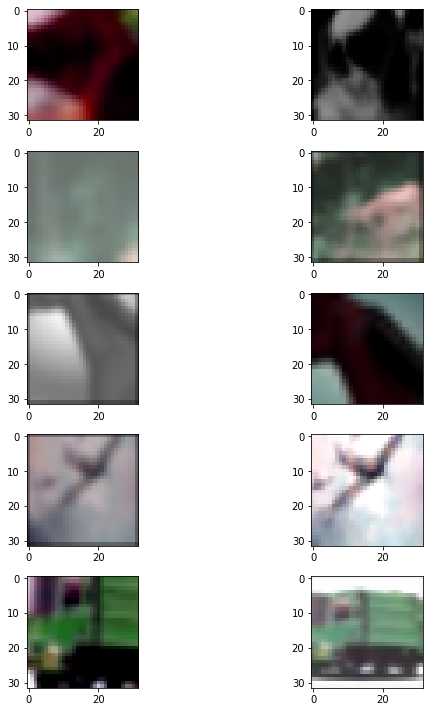

In [36]:
batch_to_vis = next(train_data.__iter__())
image_orig = batch_to_vis[0].numpy()  
image_aug = batch_to_vis[1].numpy()  

fig, axs = plt.subplots(BATCH_SIZE, 2, figsize = (10,10))
for ax_idx in range(BATCH_SIZE):
    axs[ax_idx,0].imshow(image_orig[ax_idx])
    axs[ax_idx,1].imshow(image_aug[ax_idx])
    
fig.tight_layout()
    
    